
![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F518134%2F68421364ae2731375c0f59fd1749c845%2Fpexels-ivan-samkov-4989186.jpg?generation=1611197793386796&alt=media)
<div style="text-align:center;"><cite>Image from <a href="https://www.pexels.com/ja-jp/photo/4989186/">https://www.pexels.com/ja-jp/photo/4989186/</a></cite></div>

<br/>

# VinBigData 2-class classifier complete pipeline

This competition is object detaction task to find a class and location of thoracic abnormalities from chest x-ray image (radiographs).

However, it is mentioned that training 2 class classifier to understand which is the normal image is important to get high score.
 - Kernel: [VinBigData 🌟2 Class Filter🌟](https://www.kaggle.com/awsaf49/vinbigdata-2-class-filter)
 - Discussion: [[LB0.155] baseline solution](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/208837)

Here, I will introduce complete **EDA, Training (with 5-fold cross validation) and Prediction pipeline** for training 2-class classifier.

You can learn the usage of following tools to accelerate deep learning tasks in computer vision!
 - [pytorch](https://github.com/pytorch/pytorch): Deep learning framework, it's popular among researchers for its flexible usage. no need to explain detail!
 - [albumentations](https://github.com/albumentations-team/albumentations): Image augmentation library, developed by famous kagglers!
 - [timm](https://github.com/rwightman/pytorch-image-models): pytorch-image-models, it provides a lot of popular SoTA CNN models with pretrained weights.
 - [pytorch ignite](https://github.com/pytorch/ignite): Traning/Evaluation abstraction framework on top of pytorch.
 - [pytorch pfn extras](https://github.com/pfnet/pytorch-pfn-extras): It is used to add more feature-rich functionality on Ignite.

# Table of Contents

** [Dataset preparation](#dataset)** <br/>
** [Installation](#installation)** <br/>
** [EDA: distribution between normal & abnormal class](#eda)** <br/>
** [Image visualizaion & augmentation with albumentations](#aug)** <br/>
** [Defining CNN models](#model)** <br/>
** [Training utils](#trainutil)** <br/>
** [Training scripts](#trainscript)** <br/>
** [Prediction on validation & test dataset](#prediction)** <br/>
** [Next step](#nextstep)** <br/>

<a id="dataset"></a>
# Dataset preparation

Preprocessing x-ray image format (dicom) into normal png image format is already done by @xhlulu in the below discussion:
 - [Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207955).

Here I will just use the dataset [VinBigData Chest X-ray Resized PNG (256x256)](https://www.kaggle.com/xhlulu/vinbigdata-chest-xray-resized-png-256x256) to skip the preprocessing and focus on modeling part. Please upvote the dataset as well!

In [ ]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import torch

# --- setup ---
pd.set_option('max_columns', 50)


<a id="installation"></a>
# Installation

detectron2 is not pre-installed in this kaggle docker, so let's install it. 
We can follow [installation instruction](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md), we need to know CUDA and pytorch version to install correct `detectron2`.

In [ ]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
!pip install pytorch-pfn-extras timm

This `Flags` class summarizes all the configuratoin available during the training.

As I will show later, you can change various hyperparameters to experiment improving your models!

In [ ]:
from typing import Any
import yaml

def save_yaml(filepath: str, content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)

In [ ]:
from dataclasses import dataclass, field
from typing import Dict, Any, Tuple, Union, List


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"
    device: str = "cuda:0"

    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    # split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    target_fold: int = 0  # 0~4
    label_smoothing: float = 0.0
    # Model config
    model_name: str = "resnet18"
    model_mode: str = "normal"  # normal, cnn_fixed supported
    # Training config
    epoch: int = 20
    batchsize: int = 8
    valid_batchsize: int = 16
    num_workers: int = 4
    snapshot_freq: int = 5
    ema_decay: float = 0.999  # negative value is to inactivate ema.
    scheduler_type: str = ""
    scheduler_kwargs: Dict[str, Any] = field(default_factory=lambda: {})
    scheduler_trigger: List[Union[int, str]] = field(default_factory=lambda: [1, "iteration"])
    aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    mixup_prob: float = -1.0  # Apply mixup augmentation when positive value is set.

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [ ]:
flags_dict = {
    "debug": False,  # Change to True for fast debug run!
    "outdir": "results/tmp_debug",
    # Data
    "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256",
    # Model
    "model_name": "resnet18",
    # Training
    "num_workers": 4,
    "epoch": 15,
    "batchsize": 8,
    "scheduler_type": "CosineAnnealingWarmRestarts",
    "scheduler_kwargs": {"T_0": 28125},  # 15000 * 15 epoch // (batchsize=8)
    "scheduler_trigger": [1, "iteration"],
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CoarseDropout": {"max_holes": 8, "max_height": 25, "max_width": 25, "p": 0.5},
        "Blur": {"blur_limit": [3, 7], "p": 0.5},
        "Downscale": {"scale_min": 0.25, "scale_max": 0.9, "p": 0.3},
        "RandomGamma": {"gamma_limit": [80, 120], "p": 0.6},
    }
}

In [ ]:
import dataclasses

# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(str(outdir / "flags.yaml"), flags_dict)

# --- Read data ---
inputdir = Path("/kaggle/input")
datadir = inputdir / "vinbigdata-chest-xray-abnormalities-detection"
imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
train = pd.read_csv(datadir / "train.csv")
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

<a id="eda"></a>
# EDA: distribution between normal & abnormal class

At first, let's check how many normal class exist in the training data.
It is classified as "class_name = No finding" and "class_id = 14".

However you need to be careful that 3 radiologists annotated for each image, so you can find 3 annotations as you can see below.

In [ ]:
train.query("image_id == '50a418190bc3fb1ef1633bf9678929b3'")

So the question arises, is there an image that the 3 radiologists' opinions differ?

Let's check number of "No finding" annotations for each image, if the opinions are in complete agreement the number of "No finding" annotations should be **0 -> Abnormal(all radiologists does not think this is normal)" or "1 -> Normal(all radiologists think this is normal)"**.

In [ ]:
is_normal_df = train.groupby("image_id")["class_id"].agg(lambda s: (s == 14).sum()).reset_index().rename({"class_id": "num_normal_annotations"}, axis=1)
is_normal_df.head()

We could confirm that **always 3 radiologists opinions match** for normal - abnormal diagnosis.

[Note] I noticed that it does not apply for the other classes. i.e., 3 radiologists opinions sometimes do not match for the other class of thoracic abnormalities.

In [ ]:
num_normal_anno_counts = is_normal_df["num_normal_annotations"].value_counts()
num_normal_anno_counts.plot(kind="bar")
plt.title("The number of 'No finding' annotations in each image")

In [ ]:
num_normal_anno_counts_df = num_normal_anno_counts.reset_index()
num_normal_anno_counts_df["name"] = num_normal_anno_counts_df["index"].map({0: "Abnormal", 3: "Normal"})
num_normal_anno_counts_df

So almost 70% of the data is actually "Normal" X-ray images.

Only 30% of the images need thoracic abnormality location detection.

In [ ]:
px.pie(num_normal_anno_counts_df, values="num_normal_annotations", names="name", title="Normal/Abnormal ratio")

<a id="aug"></a>
# Image visualizaion & augmentation with albumentations

When you train CNN models, image augmentation is important to avoid model to overfit.<br/>
I'll show examples to use Albumentations to run image augmentation very easily.<br/>
At first, I will define pytorch Dataset class for this competition, which can be also used later in the training.

In [ ]:
import pickle
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
):
    debug_str = f"_debug{int(debug)}"
    train_data_type_str = f"_{train_data_type}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    # This annotator does not find anything, skip.
                    pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        int(row["x_min"]) * w_ratio,
                        int(row["y_min"]) * h_ratio,
                        int(row["x_max"]) * w_ratio,
                        int(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


In [ ]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


In [ ]:
import cv2
import numpy as np


class VinbigdataTwoClassDataset(DatasetMixin):
    def __init__(self, dataset_dicts, image_transform=None, transform=None, train: bool = True,
                 mixup_prob: float = -1.0, label_smoothing: float = 0.0):
        super(VinbigdataTwoClassDataset, self).__init__(transform=transform)
        self.dataset_dicts = dataset_dicts
        self.image_transform = image_transform
        self.train = train
        self.mixup_prob = mixup_prob
        self.label_smoothing = label_smoothing

    def _get_single_example(self, i):
        d = self.dataset_dicts[i]
        filename = d["file_name"]

        img = cv2.imread(filename)
        if self.image_transform:
            img = self.image_transform(img)
        img = torch.tensor(np.transpose(img, (2, 0, 1)).astype(np.float32))

        if self.train:
            label = int(len(d["annotations"]) > 0)  # 0 normal, 1 abnormal
            if self.label_smoothing > 0:
                if label == 0:
                    return img, float(label) + self.label_smoothing
                else:
                    return img, float(label) - self.label_smoothing
            else:
                return img, float(label)
        else:
            # Only return img
            return img, None

    def get_example(self, i):
        img, label = self._get_single_example(i)
        if self.mixup_prob > 0. and np.random.uniform() < self.mixup_prob:
            j = np.random.randint(0, len(self.dataset_dicts))
            p = np.random.uniform()
            img2, label2 = self._get_single_example(j)
            img = img * p + img2 * (1 - p)
            if self.train:
                label = label * p + label2 * (1 - p)

        if self.train:
            label_logit = torch.tensor([1 - label, label], dtype=torch.float32)
            return img, label_logit
        else:
            # Only return img
            return img

    def __len__(self):
        return len(self.dataset_dicts)

Now creating the dataset is just easy as following:

In [ ]:
dataset_dicts = get_vinbigdata_dicts(imgdir, train, debug=debug)
dataset = VinbigdataTwoClassDataset(dataset_dicts)

You can access each image and its label (0=Normal, 1=Abnormal) by just access `dataset` with index.

In [ ]:
index = 0
img, label = dataset[index]
plt.imshow(img.cpu().numpy().transpose((1, 2, 0)) / 255.)
plt.title(f"{index}-th image: label {label}")

To run augmentation on this image, I will define `Transform` class which is applied each time the data is accessed.

You can refer [albumentations](https://github.com/albumentations-team/albumentations) page, that various kinds of augmentation is already implemented and can be used very easily!

In [ ]:
import albumentations as A


class Transform:
    def __init__(
        self, hflip_prob: float = 0.5, ssr_prob: float = 0.5, random_bc_prob: float = 0.5
    ):
        self.transform = A.Compose(
            [
                A.HorizontalFlip(p=hflip_prob),
                A.ShiftScaleRotate(
                    shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=ssr_prob
                ),
                A.RandomBrightnessContrast(p=random_bc_prob),
            ]
        )

    def __call__(self, image):
        image = self.transform(image=image)["image"]
        return image


To use augmentation, you can just define dataset with the `Transform` function.

In [ ]:
aug_dataset = VinbigdataTwoClassDataset(dataset_dicts, image_transform=Transform())

Let's visualize, looks good. <br/>
You can see each image looks different (rotated, brightness is different etc...) even if it is generated from the same image :)

In [ ]:
index = 0

n_images = 4

fig, axes = plt.subplots(1, n_images, figsize=(16, 5))
for i in range(n_images):
    # Each time the data is accessed, the result is different due to random augmentation!
    img, label = aug_dataset[index]
    ax = axes[i]
    ax.imshow(img.cpu().numpy().transpose((1, 2, 0)) / 255.)
    ax.set_title(f"{index}-th image: label {label}")
plt.show()

**Extend to more general form**

Augmentation is very important hyperparameter to improve model's performance, and you want to experiment with various configurations.<br/>
Below updated `Transform` function is written to **support all the augmentations implemented in albumentations**.<br/>
You can specify `aug_kwargs` from external configuration inside `flag` as follows:

```
aug_kwargs:
  HorizontalFlip: {"p": 0.5}
  ShiftScaleRotate: {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5}
  RandomBrightnessContrast: {"p": 0.5}
  CoarseDropout: {"max_holes": 8, "max_height": 25, "max_width": 25, "p": 0.5}
  Blur: {"blur_limit": [3, 7], "p": 0.5}
  Downscale: {"scale_min": 0.25, "scale_max": 0.9, "p": 0.3}
  RandomGamma: {"gamma_limit": [80, 120], "p": 0.6}
```

In [ ]:
from typing import Dict

import albumentations as A


class Transform:
    def __init__(self, aug_kwargs: Dict):
        self.transform = A.Compose(
            [getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()]
        )

    def __call__(self, image):
        image = self.transform(image=image)["image"]
        return image

<a id="model"></a>
# Defining CNN models

Recently, several libraries of CNN-collection are available on public.

I will use `timm` this time. You don't need to impelment deep CNN models by yourself, you can just re-use latest research results without hustle.<br/>
You can focus on more about looking data and try experiment now.

In [ ]:
from torch import nn
from torch.nn import Linear


class CNNFixedPredictor(nn.Module):
    def __init__(self, cnn: nn.Module, num_classes: int = 2):
        super(CNNFixedPredictor, self).__init__()
        self.cnn = cnn
        self.lin = Linear(cnn.num_features, num_classes)
        print("cnn.num_features", cnn.num_features)

        # We do not learn CNN parameters.
        # https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
        for param in self.cnn.parameters():
            param.requires_grad = False

    def forward(self, x):
        feat = self.cnn(x)
        return self.lin(feat)


In [ ]:
import timm


def build_predictor(model_name: str, model_mode: str = "normal"):
    if model_mode == "normal":
        # normal configuration. train all parameters.
        return timm.create_model(model_name, pretrained=True, num_classes=2, in_chans=3)
    elif model_mode == "cnn_fixed":
        # normal configuration. train all parameters.
        # https://rwightman.github.io/pytorch-image-models/feature_extraction/
        timm_model = timm.create_model(model_name, pretrained=True, num_classes=0, in_chans=3)
        return CNNFixedPredictor(timm_model, num_classes=2)
    else:
        raise ValueError(f"[ERROR] Unexpected value model_mode={model_mode}")


In [ ]:
import torch


def accuracy(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape[:-1] == t.shape, f"y {y.shape}, t {t.shape} is inconsistent."
    pred_label = torch.max(y.detach(), dim=-1)[1]
    count = t.nelement()
    correct = (pred_label == t).sum().float()
    acc = correct / count
    return acc


def accuracy_with_logits(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape == t.shape
    gt_label = torch.max(t.detach(), dim=-1)[1]
    return accuracy(y, gt_label)

In [ ]:
import torch
import torch.nn.functional as F


def cross_entropy_with_logits(input, target, dim=-1):
    loss = torch.sum(- target * F.log_softmax(input, dim), dim)
    return loss.mean()


In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import pytorch_pfn_extras as ppe


class Classifier(nn.Module):
    """two class classfication"""

    def __init__(self, predictor, lossfun=cross_entropy_with_logits):
        super().__init__()
        self.predictor = predictor
        self.lossfun = lossfun
        self.prefix = ""

    def forward(self, image, targets):
        outputs = self.predictor(image)
        loss = self.lossfun(outputs, targets)
        metrics = {
            f"{self.prefix}loss": loss.item(),
            f"{self.prefix}acc": accuracy_with_logits(outputs, targets).item()
        }
        ppe.reporting.report(metrics, self)
        return loss, metrics

    def predict(self, data_loader):
        pred = self.predict_proba(data_loader)
        label = torch.argmax(pred, dim=1)
        return label

    def predict_proba(self, data_loader):
        device: torch.device = next(self.parameters()).device
        y_list = []
        self.eval()
        with torch.no_grad():
            for batch in data_loader:
                if isinstance(batch, (tuple, list)):
                    # Assumes first argument is "image"
                    batch = batch[0].to(device)
                else:
                    batch = batch.to(device)
                y = self.predictor(batch)
                y = torch.softmax(y, dim=-1)
                y_list.append(y)
        pred = torch.cat(y_list)
        return pred


What kind of models are supported in the `timm` library?

In [ ]:
supported_models = timm.list_models()
print(f"{len(supported_models)} models are supported in timm.")
print(supported_models)

Wow more than 300 models are supported!<br/>
It of course includes **resnet** related models, **efficientnet**, etc.<br/>
You may wonder which model should be used?<br/>
I will go with `resnet18` as a baseline at first, and try using more deeper/latest models in the experiment.

<a id="trainutil"></a>
# Training utils

Here are training util methods. You can just copy these to use in other projects.

In [ ]:
"""
From https://github.com/pfnet-research/kaggle-lyft-motion-prediction-4th-place-solution
"""
from logging import getLogger

from torch import nn


class EMA(object):
    """Exponential moving average of model parameters.

    Ref
     - https://github.com/tensorflow/addons/blob/v0.10.0/tensorflow_addons/optimizers/moving_average.py#L26-L103
     - https://anmoljoshi.com/Pytorch-Dicussions/

    Args:
        model (nn.Module): Model with parameters whose EMA will be kept.
        decay (float): Decay rate for exponential moving average.
        strict (bool): Apply strict check for `assign` & `resume`.
        use_dynamic_decay (bool): Dynamically change decay rate. If `True`, small decay rate is
            used at the beginning of training to move moving average faster.
    """  # NOQA

    def __init__(
        self,
        model: nn.Module,
        decay: float,
        strict: bool = True,
        use_dynamic_decay: bool = True,
    ):
        self.decay = decay
        self.model = model
        self.strict = strict
        self.use_dynamic_decay = use_dynamic_decay
        self.logger = getLogger(__name__)
        self.n_step = 0

        self.shadow = {}
        self.original = {}

        # Flag to manage which parameter is assigned.
        # When `False`, original model's parameter is used.
        # When `True` (`assign` method is called), `shadow` parameter (ema param) is used.
        self._assigned = False

        # Register model parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def step(self):
        self.n_step += 1
        if self.use_dynamic_decay:
            _n_step = float(self.n_step)
            decay = min(self.decay, (1.0 + _n_step) / (10.0 + _n_step))
        else:
            decay = self.decay

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - decay) * param.data + decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    # alias
    __call__ = step

    def assign(self):
        """Assign exponential moving average of parameter values to the respective parameters."""
        if self._assigned:
            if self.strict:
                raise ValueError("[ERROR] `assign` is called again before `resume`.")
            else:
                self.logger.warning(
                    "`assign` is called again before `resume`."
                    "shadow parameter is already assigned, skip."
                )
                return

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.original[name] = param.data.clone()
                param.data = self.shadow[name]
        self._assigned = True

    def resume(self):
        """Restore original parameters to a model.

        That is, put back the values that were in each parameter at the last call to `assign`.
        """
        if not self._assigned:
            if self.strict:
                raise ValueError("[ERROR] `resume` is called before `assign`.")
            else:
                self.logger.warning("`resume` is called before `assign`, skip.")
                return

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.original[name]
        self._assigned = False


In [ ]:
"""
From https://github.com/pfnet-research/kaggle-lyft-motion-prediction-4th-place-solution
"""
from typing import Mapping, Any

from torch import optim

from pytorch_pfn_extras.training.extension import Extension, PRIORITY_READER
from pytorch_pfn_extras.training.manager import ExtensionsManager


class LRScheduler(Extension):
    """A thin wrapper to resume the lr_scheduler"""

    trigger = 1, 'iteration'
    priority = PRIORITY_READER
    name = None

    def __init__(self, optimizer: optim.Optimizer, scheduler_type: str, scheduler_kwargs: Mapping[str, Any]) -> None:
        super().__init__()
        self.scheduler = getattr(optim.lr_scheduler, scheduler_type)(optimizer, **scheduler_kwargs)

    def __call__(self, manager: ExtensionsManager) -> None:
        self.scheduler.step()

    def state_dict(self) -> None:
        return self.scheduler.state_dict()

    def load_state_dict(self, to_load) -> None:
        self.scheduler.load_state_dict(to_load)


In [ ]:
from ignite.engine import Engine


def create_trainer(model, optimizer, device) -> Engine:
    model.to(device)

    def update_fn(engine, batch):
        model.train()
        optimizer.zero_grad()
        loss, metrics = model(*[elem.to(device) for elem in batch])
        loss.backward()
        optimizer.step()
        return metrics
    trainer = Engine(update_fn)
    return trainer


<a id="trainscript"></a>
# Training scripts

In [ ]:
import dataclasses
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import pytorch_pfn_extras.training.extensions as E
import torch
from ignite.engine import Events
from pytorch_pfn_extras.training import IgniteExtensionsManager
from sklearn.model_selection import StratifiedKFold
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader

## Preparing data by 5-fold cross validation

When we have few data, running stable evaluation is very important. 
We can use cross validation to reduce validation error standard deviation.

Here, I will use **[`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)** to keep the balance between normal/abnormal ratio same for the train & validation dataset.

According to [this discussion](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/208837#1139712), using multi label stratified kfold https://github.com/trent-b/iterative-stratification may be more stable.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=flags.seed)
# skf.get_n_splits(None, None)
y = np.array([int(len(d["annotations"]) > 0) for d in dataset_dicts])
split_inds = list(skf.split(dataset_dicts, y))
train_inds, valid_inds = split_inds[flags.target_fold]  # 0th fold
train_dataset = VinbigdataTwoClassDataset(
    [dataset_dicts[i] for i in train_inds],
    image_transform=Transform(flags.aug_kwargs),
    mixup_prob=flags.mixup_prob,
    label_smoothing=flags.label_smoothing,
)
valid_dataset = VinbigdataTwoClassDataset([dataset_dicts[i] for i in valid_inds])


## Write training code

pytorch-ignite & pytorch-pfn-extras are used here.

 - [pytorch/ignite](https://github.com/pytorch/ignite): It provides abstraction for writing training loop.
 - [pfnet/pytorch-pfn-extras](https://github.com/pfnet/pytorch-pfn-extras): It provides several "extensions" useful for training. Useful for **logging, printing, evaluating, saving the model, scheduling the learning rate** during training.
 
**[Note] Why training abstraction library is used?**

You may feel understanding training abstraction code below is a bit unintuitive compared to writing "raw" training loop.<br/>
The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br/>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.
These are done by provided util classes in `pytorch-pfn-extras` library!

You may refer my other kernel in previous competition too:
 - [Bengali: SEResNeXt training with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-training-with-pytorch)
 - [Lyft: Training with multi-mode confidence](https://www.kaggle.com/corochann/lyft-training-with-multi-mode-confidence)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=flags.batchsize,
    num_workers=flags.num_workers,
    shuffle=True,
    pin_memory=True,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=flags.valid_batchsize,
    num_workers=flags.num_workers,
    shuffle=False,
    pin_memory=True,
)

device = torch.device(flags.device)

predictor = build_predictor(model_name=flags.model_name, model_mode=flags.model_mode)
classifier = Classifier(predictor)
model = classifier
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=1e-3)

# Train setup
trainer = create_trainer(model, optimizer, device)

ema = EMA(predictor, decay=flags.ema_decay)

def eval_func(*batch):
    loss, metrics = model(*[elem.to(device) for elem in batch])
    # HACKING: report ema value with prefix.
    if flags.ema_decay > 0:
        classifier.prefix = "ema_"
        ema.assign()
        loss, metrics = model(*[elem.to(device) for elem in batch])
        ema.resume()
        classifier.prefix = ""

valid_evaluator = E.Evaluator(
    valid_loader, model, progress_bar=False, eval_func=eval_func, device=device
)

# log_trigger = (10 if debug else 1000, "iteration")
log_trigger = (1, "epoch")
log_report = E.LogReport(trigger=log_trigger)
extensions = [
    log_report,
    E.ProgressBarNotebook(update_interval=10 if debug else 100),  # Show progress bar during training
    E.PrintReportNotebook(),  # Show "log" on jupyter notebook  
    # E.ProgressBar(update_interval=10 if debug else 100),  # Show progress bar during training
    # E.PrintReport(),  # Print "log" to terminal
    E.FailOnNonNumber(),  # Stop training when nan is detected.
]
epoch = flags.epoch
models = {"main": model}
optimizers = {"main": optimizer}
manager = IgniteExtensionsManager(
    trainer, models, optimizers, epoch, extensions=extensions, out_dir=str(outdir),
)
# Run evaluation for valid dataset in each epoch.
manager.extend(valid_evaluator)

# Save predictor.pt every epoch
manager.extend(
    E.snapshot_object(predictor, "predictor.pt"), trigger=(flags.snapshot_freq, "epoch")
)
# Check & Save best validation predictor.pt every epoch
# manager.extend(E.snapshot_object(predictor, "best_predictor.pt"),
#                trigger=MinValueTrigger("validation/module/nll",
#                trigger=(flags.snapshot_freq, "iteration")))

# --- lr scheduler ---
if flags.scheduler_type != "":
    scheduler_type = flags.scheduler_type
    print(f"using {scheduler_type} scheduler with kwargs {flags.scheduler_kwargs}")
    manager.extend(
        LRScheduler(optimizer, scheduler_type, flags.scheduler_kwargs),
        trigger=flags.scheduler_trigger,
    )

manager.extend(E.observe_lr(optimizer=optimizer), trigger=log_trigger)

if flags.ema_decay > 0:
    # Exponential moving average
    manager.extend(lambda manager: ema(), trigger=(1, "iteration"))

    def save_ema_model(manager):
        ema.assign()
        torch.save(predictor.state_dict(), outdir / "predictor_ema.pt")
        ema.resume()

    manager.extend(save_ema_model, trigger=(flags.snapshot_freq, "epoch"))

_ = trainer.run(train_loader, max_epochs=epoch)

So what is happening in above training abstraction? Let's understand what each extension did.

**Extensions** - Each role:
 - **`ProgressBar` (`ProgressBarNotebook`)**: Shows training progress in formatted style.
 - **`LogReport`**: Logging metrics reported by `ppe.reporter.report` (see `LyftMultiRegressor` for reporting point) method and save to **log** file. It automatically collects reported value in each iteration and saves the "mean" of reported value for regular frequency (for example every 1 epoch).
 - **`PrintReport` (`PrintReportNotebook`)**: Prints the value which `LogReport` collected in formatted style.
 - **`Evaluator`**: Evaluate on validation dataset.
 - **`snapshot_object`**: Saves the object. Here the `model` is saved in regular interval `flags.snapshot_freq`. Even you quit training using Ctrl+C without finishing all the epoch, the intermediate trained model is saved and you can use it for inference.
 - **`LRScheduler`**: You can insert learning rate scheduling with this extension, together with the regular interval call specified by `trigger`. Here cosine annealing is applied (configured by Flags) by calling `scheduler.step()` every iteration.
 - **`observe_lr`**: `LogReport` will check optimizer's learning rate using this extension. So you can follow how the learning rate changed through the training.


Such many functionalities can be "added" easily using extensions!

Also **Exponential Moving Average of model weights** is calculated by `EMA` class during training, together with showing its validation loss. We can usually obtrain more stable models with EMA.

You can obtrain training history results really easily by just accessing `LogReport` class, which is useful for managing a lot of experiments during kaggle competitions.

In [ ]:
torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
df = log_report.to_dataframe()
df.to_csv(outdir / "log.csv", index=False)
df

<a id="prediction"></a>
# Prediction on validation & test dataset

In [ ]:
# --- Prediction ---
print("Training done! Start prediction...")
# valid data
valid_pred = classifier.predict_proba(valid_loader).cpu().numpy()
valid_pred_df = pd.DataFrame({
    "image_id": [dataset_dicts[i]["image_id"] for i in valid_inds],
    "class0": valid_pred[:, 0],
    "class1": valid_pred[:, 1]
})
valid_pred_df.to_csv(outdir/"valid_pred.csv", index=False)

# test data
test_meta = pd.read_csv(inputdir / "vinbigdata-testmeta" / "test_meta.csv")
dataset_dicts_test = get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)
test_dataset = VinbigdataTwoClassDataset(dataset_dicts_test, train=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=flags.valid_batchsize,
    num_workers=flags.num_workers,
    shuffle=False,
    pin_memory=True,
)
test_pred = classifier.predict_proba(test_loader).cpu().numpy()
test_pred_df = pd.DataFrame({
    "image_id": [d["image_id"] for d in dataset_dicts_test],
    "class0": test_pred[:, 0],
    "class1": test_pred[:, 1]
})
test_pred_df.to_csv(outdir/"test_pred.csv", index=False)

In [ ]:
# --- Test dataset prediction result ---
test_pred_df

In [ ]:
sns.distplot(valid_pred_df["class0"].values, color='green', label='valid pred')
sns.distplot(test_pred_df["class0"].values, color='orange', label='test pred')
plt.title("Prediction results histogram")
plt.xlim([0., 1.])
plt.legend()

# Apply 2 class filter on detection prediction

I will use detection prediction from the kernel:
 - [📸VinBigData detectron2 train](https://www.kaggle.com/corochann/vinbigdata-detectron2-train)
 - [📸VinBigData detectron2 prediction](https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction)

And 2class prediction is updated as dataset: [vinbigdata-2class-pred](https://www.kaggle.com/corochann/vinbigdata2classpred).

As mentioned in [VinBigData 🌟2 Class Filter🌟](https://www.kaggle.com/awsaf49/vinbigdata-2-class-filter) by @awsaf49, applying 2-class filter improves LB score significantly. (Please upvote his kernel as well!)<br/>
Also, it is mentioned that we can submit **14 prob 1 1 0 0** where the `prob` is the normal probability in the discussion [[Scoring bug] Improve your LB score by 0.053, just adding "14 1 0 0 1 1"](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211971)!

Here, I will propose new post processing (similar to [this](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211971#1157809) by @pestipeti):

Here `p` is the **normal probability**.

1. `p < low_threshold`                   -> Do nothing, Keep det prediction.
2. `low_threshold <= p < high_threshold` -> Just "Add" Normal prediction, **keep** detection prediction.
3. `high_threshold <= p`                 -> Replace with Normal prediction with normal score 1.0, **remove** all detection predictoin.


[Note] I also wrote another kernel to train 2-class model: [📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline) to train these 2-class classifier model!

In [ ]:
#pred_2class = pd.read_csv(inputdir/"vinbigdata-2class-prediction/2-cls test pred.csv")
pred_2class = pd.read_csv(inputdir/"vinbigdata2classpred/test_pred.csv")
pred_2class

In [ ]:
NORMAL = "14 1 0 0 1 1"
low_threshold = 0.0
high_threshold = 0.976

pred_det_df = pd.read_csv(inputdir/"vinbigdata-detectron2-prediction/results/20210125_all_alb_aug_512_cos/submission.csv")  # You can load from another submission.csv here too.
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")

# 1. p < low_threshold                   -> "Keep": Do nothing, Keep det prediction.
# 2. low_threshold <= p < high_threshold -> "Add": Just "Add" Normal prediction
# 3. high_threshold <= p                 -> "Replace": Replace with Normal prediction

if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:
        # Keep, do nothing.
        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:
        # Add, keep "det" preds and add normal pred.
        merged_df.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:
        # Replace, remove all "det" preds.
        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str(outdir / "submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

In my experiment:
 - The baseline submission: score 0.141
 - Just replace by threshold ([version3](https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction?scriptVersionId=52412540) ): score 0.206
 - This post process (combine replace & add): **0.221**

So the score improved by about **0.8, which is significant**!

In more detail, I tried to change several `low_threshold` value and lower `low_threshold` achieved better results. So it may be okay to set `low_threshold=0.0` which means **always add "No finding" prediction with the predicted probability.**<br/>
I also noticed that setting `high_threshold` value less than 1 is important, which means we have a benefit to **remove abnormality predictions** for the images which is highly likely to be normal.<br/>
This may be because my [training kernel](https://www.kaggle.com/corochann/vinbigdata-detectron2-train) currently only uses abnormal image during training and model tend to produce more abnormal boxes. I'm now thinking that it's better to include normal images for training to learn where there is **no** abnormality.<br/>
Also, I think it's nice to try **including "No finding" class during detection training** (by adding virtual "No finding" boxes, or by adding global classifier together with the detection).

That's all!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated 😁<br>Thanks!</h3>

<a id="nextstep"></a>
# Next step

I explained EDA - Training - Prediction pipeline for 2-class image classification in this kernel.<br/>
You can try changing training configurations by just changing `Flags` (`flags_dict`) configuration.

For example, you can change these paramters:

 - **Data**
   - `imgdir_name`: You can use different preprocessed image introduced in [Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207955) by @xhlulu.
 - **Model**
   - `model_name`: You can try various kinds of models `timm` library support, by just changing model_name.
 - **Training**
   - `epoch`, `batch_size`, `scheduler_type` etc: Try changing these hyperparamters, to see the difference!
   - Augmentation: Please modify `Transform` class to add your augmentation, it's easy to support more augmentations with `albumentations` library.


My basic strategy is as follows:
 - Check training loss/training accuracy: If it is almost same with validation loss/accuracy and it is not accurate enough, model's representation power may be not enough, or data augmentation is too strong. You can try more deeper models, decrease data augmentation or using more rich data (high-resolution image).
 - Check training loss/validation loss difference: If validation loss is very high compared to training loss, it is a sign of overfitting. Try using smaller models, increase data augmentation or apply regularization (dropout etc).

**Using other datasets?**

There are several other X-ray images in this research field.
The paper of this competition dataset "VinDr-CXR: An open dataset of chest X-rays with radiologist's annotations”. summarizes the existing public datasets. 

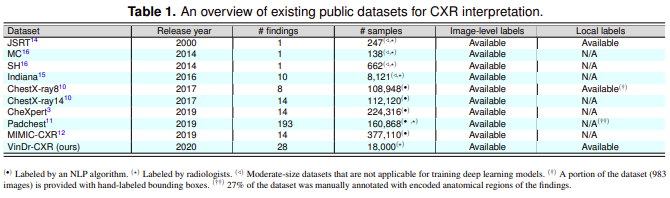

[CheXpert](https://stanfordmlgroup.github.io/competitions/chexpert/) is one of the biggest dataset in this area.
Even if local label (for detection) is not available, it helps to create more accurate model by combining to use this dataset.
You can register your name and E-mail address to Download this Dataset!

# Next to read

[📸VinBigData detectron2 train](https://www.kaggle.com/corochann/vinbigdata-detectron2-train) kernel explains how to run object detection training, using `detectron2` library.

[📸VinBigData detectron2 prediction](https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction) kernel explains how to use trained model for the prediction and submisssion for this competition.